In [1]:
# load libraies

%run py_libraries.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# loading utility files

from utility.sv_fig import savefig
from utility.make_cm import make_confusion_matrix
from utility.get_g_result import get_gamma_results
from utility.plt_result import plot_results

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


In [4]:
def savefig(filename, crop = True):
    plt.savefig('{}.pdf'.format(filename))

In [5]:
# load data
train_data = pd.read_csv('data/Xy_PCa_Ca_md.csv')
test_data = pd.read_csv('data/Xy_test_PCa_Ca_md.csv')

In [6]:
all_col_names = train_data.columns.tolist()

print(all_col_names)

['ENA.78', 'IFN.y', 'IL.10', 'IL.6', 'IL.8', 'MCP.1', 'MDC', 'MIP.1a', 'TNF.a', 'C.peptide', 'G.CSF', 'IL.22', 'Insulin', 'Leptin', 'MIP.3a', 'GRO.a', 'HGF', 'MMP.2', 'Adiponectin', 'CRP', 'GDF.15', 'TIMP.1', 'TGF.B2', 'TGF.B1', 'PPAR.y', 'HIF.1a', 'Laminin', 'HbA1c', 'CA19.9', 'Glucose', 'HDL', 'CCK', 'LDL', 'Triglyceride', 'Albumin', 'Lumican', 'ZAG', 'CACHEXSTAGE0VIG']


In [7]:
#

# train_data = train_data.drop(['ENA.78','C.peptide','GRO.a','PPAR.y','HIF.1a','Laminin','HbA1c','Lumican','ZAG','Albumin','MIP.3a'], axis=1) # BMC_cancer 
# train_data = train_data.drop(['GRO.a','TNF.a','C.peptide','TIMP.1', 'IL.6'], axis=1) # 0.75 / 0.25
# train_data = train_data.drop(['IL.10','GRO.a','CRP','TIMP.1'], axis=1) # 0.70 / 0.30 RND_ST 12

train_data = train_data.drop(['TNF.a','GRO.a','IL.6','TIMP.1'], axis=1) # 0.70 / 0.30 RND_ST 1234



Dataset Information:
  - Number of samples: 109
  - Number of features: 33
  - Task type: classification
  - Class distribution: {0.0: 72, 1.0: 37}

Generating learning curve for Logistic Regression...
Generating learning curve for Random Forest...
Generating learning curve for Gradient Boosting...
Generating learning curve for RBF-SVM...
Figure saved to figs/learning_curves_PCa_Ca.pdf


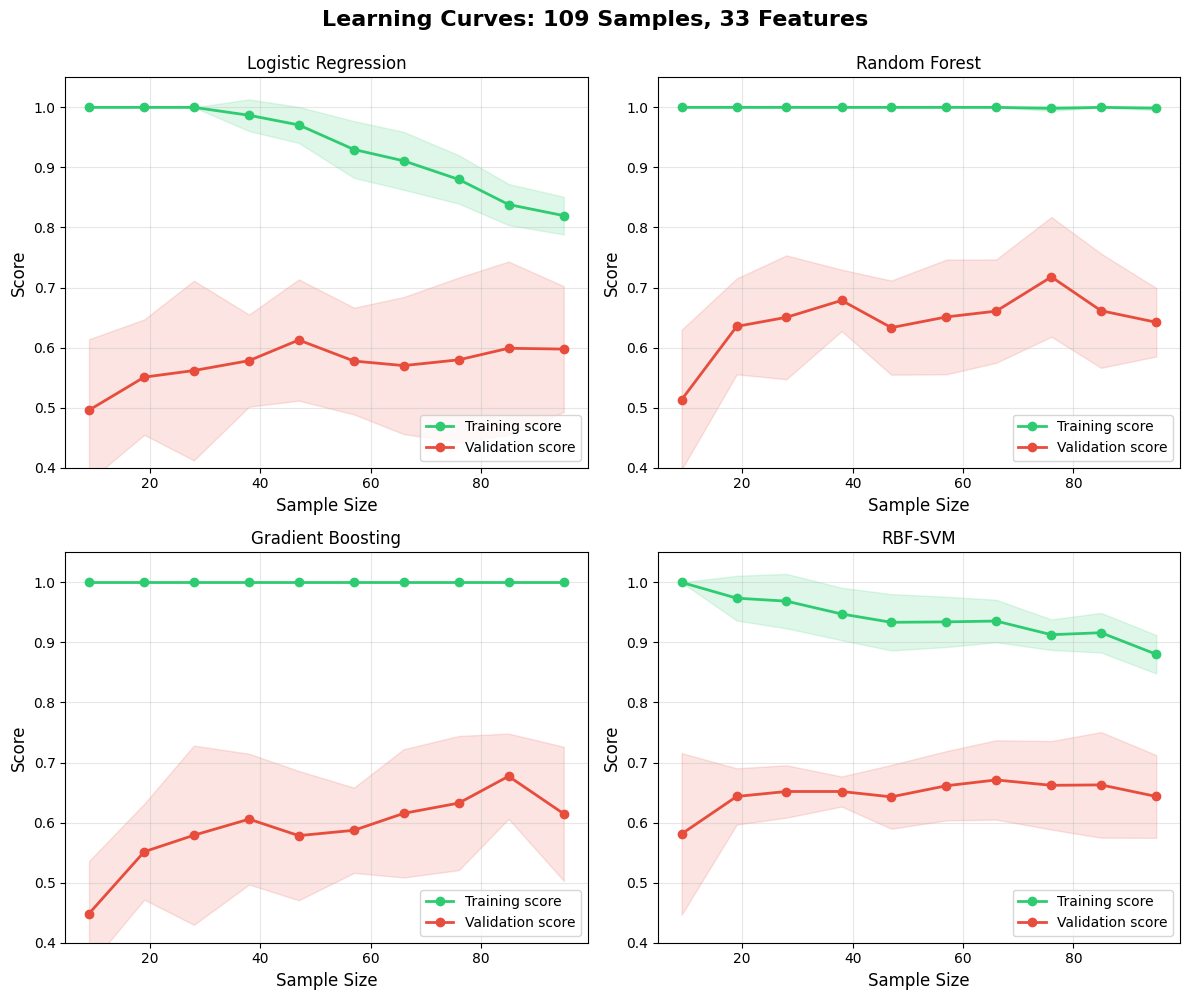

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

class LearningCurveAnalyzer:
    
    def __init__(self, X, y, task_type='classification'):
        self.X = X
        self.y = y
        self.task_type = task_type
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        
        print(f"Dataset Information:")
        print(f"  - Number of samples: {self.n_samples}")
        print(f"  - Number of features: {self.n_features}")
        print(f"  - Task type: {self.task_type}")
        if task_type == 'classification':
            unique, counts = np.unique(y, return_counts=True)
            print(f"  - Class distribution: {dict(zip(unique, counts))}")
        print()
    
    def generate_learning_curves(self, models=None, cv=8, n_jobs=-1):
        if models is None:
            models = self._get_default_models()
        
        # Define training sizes (percentage of total training data)
        train_sizes = np.linspace(0.1, 1.0, 10)
        
        results = {}
        
        for model_name, model in models.items():
            print(f"Generating learning curve for {model_name}...")
            
            # Generate learning curve
            train_sizes_abs, train_scores, val_scores = learning_curve(
                model, self.X, self.y,
                train_sizes=train_sizes,
                cv=cv,
                scoring='accuracy' if self.task_type == 'classification' else 'r2',
                n_jobs=n_jobs,
                random_state=42,
                shuffle=True
            )
            
            results[model_name] = {
                'train_sizes': train_sizes_abs,
                'train_scores_mean': np.mean(train_scores, axis=1),
                'train_scores_std': np.std(train_scores, axis=1),
                'val_scores_mean': np.mean(val_scores, axis=1),
                'val_scores_std': np.std(val_scores, axis=1)
            }
        
        self.results = results
        return results
    
    def plot_learning_curves(self, figsize=(12, 10), save_path=None):
        if not hasattr(self, 'results'):
            raise ValueError("Must run generate_learning_curves() first")
        
        n_models = len(self.results)
        n_cols = 2
        n_rows = (n_models + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten() if n_models > 1 else [axes]
        
        for idx, (model_name, result) in enumerate(self.results.items()):
            ax = axes[idx]
            
            # Plot training scores
            ax.plot(result['train_sizes'], result['train_scores_mean'],
                   'o-', color='#2ecc71', linewidth=2, markersize=6,
                   label='Training score')
            ax.fill_between(result['train_sizes'],
                           result['train_scores_mean'] - result['train_scores_std'],
                           result['train_scores_mean'] + result['train_scores_std'],
                           alpha=0.15, color='#2ecc71')
            
            # Plot validation scores
            ax.plot(result['train_sizes'], result['val_scores_mean'],
                   'o-', color='#e74c3c', linewidth=2, markersize=6,
                   label='Validation score')
            ax.fill_between(result['train_sizes'],
                           result['val_scores_mean'] - result['val_scores_std'],
                           result['val_scores_mean'] + result['val_scores_std'],
                           alpha=0.15, color='#e74c3c')
            
            # Calculate convergence metrics
            gap = result['train_scores_mean'][-1] - result['val_scores_mean'][-1]
            val_improvement = result['val_scores_mean'][-1] - result['val_scores_mean'][0]
            
            ax.set_xlabel('Sample Size', fontsize=12) #, fontweight='bold')
            ax.set_ylabel('Score', fontsize=12) #, fontweight='bold')
            ax.set_title(f'{model_name}') #\nGap: {gap:.3f} | Val Improvement: {val_improvement:.3f}',
                        #fontsize=12, fontweight='bold')
            ax.legend(loc='lower right', frameon=True, shadow=False)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0.40, 1.05])
        
        # Hide unused subplots
        for idx in range(n_models, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Learning Curves: ' f'{self.n_samples} Samples, {self.n_features} Features',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Dataset Adequacy Assessment\n' +
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {save_path}")
        
        return fig
    
    def _get_default_models(self):
        if self.task_type == 'classification':
            return {
                'Logistic Regression': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', LogisticRegression(max_iter=1000, random_state=42))
                ]),
                'Random Forest': RandomForestClassifier(
                    n_estimators=100, random_state=42, max_depth=5
                ),
                'Gradient Boosting': GradientBoostingClassifier(
                    n_estimators=100, random_state=42, max_depth=3
                ),
                'RBF-SVM': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', SVC(kernel='rbf', random_state=42))
                ])
            }
        else:
            from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
            from sklearn.svm import SVR
            from sklearn.linear_model import Ridge
            
            return {
                'Ridge Regression': Pipeline([
                    ('scaler', StandardScaler()),
                    ('reg', Ridge(random_state=42))
                ]),
                'Random Forest': RandomForestRegressor(
                    n_estimators=100, random_state=42, max_depth=5
                ),
                'Gradient Boosting': GradientBoostingRegressor(
                    n_estimators=100, random_state=42, max_depth=3
                ),
                'SVR': Pipeline([
                    ('scaler', StandardScaler()),
                    ('reg', SVR(kernel='rbf'))
                ])
            }


if __name__ == "__main__":
    
    # Load your data
    X = train_data.iloc[:,:-1]
    y = train_data.iloc[:, -1] #.values
    
    # Run analysis
    analyzer = LearningCurveAnalyzer(X, y, task_type='classification')
    analyzer.generate_learning_curves()
    analyzer.plot_learning_curves(save_path='figs/learning_curves_PCa_Ca.pdf')
    
    
